In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler

In [24]:
import sys
sys.path.append('../scripts')
import data_cleaning as cd

In [25]:
### Import data sources ###

# Training data
train = pd.read_csv('../data/train.csv')

#Previously purchased subscriptions by account
subscriptions = pd.read_csv('../data/subscriptions.csv')
#display(subscriptions.head())

# Location info for each patron and donation history
accounts = pd.read_csv('../data/account.csv')
#display(accounts.head())

# Previous concerts by season
concerts = pd.read_csv('../data/concerts.csv')
#display(concerts.head())

# List of planned concert sets for the 2014-15 season
planned_concerts = pd.read_csv('../data/concerts_2014-15.csv')
#display(planned_concerts.head())

# Previously purchased tickets by account
tickets = pd.read_csv('../data/tickets_all.csv')
#display(tickets.head())

# Location and demographic information for zipcodes
zipcodes = pd.read_csv('../data/zipcodes.csv')
#display(zipcodes.head())

# Final test data
final_test = pd.read_csv('../data/test.csv')

In [26]:
subscriptions, accounts, concerts, planned_concerts, tickets, zipcodes = cd.clean_data(subscriptions, accounts, concerts, planned_concerts, tickets, zipcodes)

Missing subscriptions data:  account.id              0
season                  0
package                 6
no.seats                0
location                6
section              4543
price.level          3534
subscription_tier       0
multiple.subs           0
dtype: int64 out of 28627 

Dropping rows with missing data...
Initial length of subscriptions:  28627
Length of subscriptions after cleaning:  24083
Encoding subscriptions categorical columns...
Missing accounts data:  account.id                     0
shipping.zip.code          19569
billing.zip.code            2955
shipping.city              19561
billing.city                2218
relationship               19172
amount.donated.2013            0
amount.donated.lifetime        0
no.donations.lifetime          0
first.donated              14298
dtype: int64 out of 19833 

Dropping rows with missing data...
Initial length of accounts:  19833
Length of accounts after cleaning:  5535
Missing concerts data:  season          0
concer

/Users/jc/code/kaggle/philarmoniab-kaggle/notebooks/../scripts/data_cleaning.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subscriptions['section'] = subscriptions['section'].map(sections_map)
/Users/jc/code/kaggle/philarmoniab-kaggle/notebooks/../scripts/data_cleaning.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tickets['price.level'] = label_encoder.fit_transform(tickets['price.level'])


In [27]:
def add_features(X):
    if 'ID' not in X.columns:
        X['ID'] = X['account.id']

    subs_by_acc = subscriptions.groupby(['account.id'])
    subscriptions_by_account = pd.DataFrame({'num_subscriptions':subs_by_acc.size(), 
                                                'avg_seats_by_subscription': subs_by_acc['no.seats'].mean(),
                                                'sub_tier': subs_by_acc['subscription_tier'].apply(lambda x: x.mode().iloc[0]),
                                                'sub_seasons': subs_by_acc['season'].unique()
                                                }).reset_index()
    
    #########################
    # Subscription features #
    #########################
    
    
    X['total_spent_in_subscriptions'] = X['ID'].map(subscriptions.groupby(['account.id'])['price.level'].sum())
    X['total_spent_in_subscriptions'] = X['total_spent_in_subscriptions'].fillna(0)

    #####################
    # Concerts features #
    #####################
    # group concerts by season and aggregate list of unique conductors
    concerts['conductor'] = concerts['who'].apply(lambda x: x.split(',')[0])
    conductors_by_season = concerts.groupby(['season'])['conductor'].unique().reset_index()

    # create new column conductors in subscriptions_by_account with all the unique values as a flattened list from conductors_by_season where the season is one of the sub_seasons
    subscriptions_by_account['conductors'] = subscriptions_by_account['sub_seasons'].apply(lambda x: set([item for sublist in conductors_by_season[conductors_by_season['season'].isin(x)]['conductor'] for item in sublist]))

    # transform "who" column in planned_concerts to "conductors" column with just the name of the conductors
    planned_concerts['conductors'] = planned_concerts['who'].apply(lambda x: x.split(',')[0])
    
    # aggregate list of unique conductors in next season
    planned_conductors = planned_concerts['conductors'].unique()
    subscriptions_by_account['watched_conductors'] = subscriptions_by_account['conductors'].apply(lambda x: len(x.intersection(planned_conductors)))
    subscriptions_by_account.drop(['sub_seasons', 'conductors'], axis=1, inplace=True)

    X['watched_conductors'] = X['ID'].map(subscriptions_by_account.set_index('account.id')['watched_conductors'])
    X['watched_conductors'] = X['watched_conductors'].fillna(0)

    ####################
    # Account features #
    ####################
    X['total_donated'] = X['ID'].map(accounts.groupby(['account.id'])['amount.donated.lifetime'].sum())
    X['total_donated'] = X['total_donated'].fillna(0)
    
    display(X.head())

    return X

In [28]:
def train_lr(X_train_scaled, y_train, X_val_scaled, y_val):
    auroc_scores = []
    c_vals = np.arange(0.1,5,0.1)
    for c in c_vals:
        model = LogisticRegression(penalty='l2',C=c)
        scores = cross_val_score(model,X_train_scaled,y_train,scoring='roc_auc',cv=5)
        auroc_scores.append(np.mean(scores))

    plt.plot(c_vals,auroc_scores)
    opt_c = c_vals[np.argmax(auroc_scores)]
    plt.title('Optimal penalty C is {:.3f}'.format(opt_c))
    plt.xlabel('C (1/lambda)')
    plt.ylabel('Cross-validated auroc score')
    plt.show()


    # Retrain the final model on the full training set and calculate the test set accuracy
    final_model = LogisticRegression(penalty='l2',C=opt_c,random_state=0)
    final_model.fit(X_train_scaled,y_train)
    val_preds = final_model.predict(X_val_scaled)
    auroc = roc_auc_score(y_val,val_preds)
    print('AUROC on test set is {:.3f}'.format(auroc))

    return final_model, auroc

In [29]:
def train_linear_svc(X_train_scaled, y_train, X_val_scaled, y_val):
    auroc_scores = []
    c_vals = np.arange(0.1,5,0.1)
    for c in c_vals:
        model = SVC(kernel='linear', C=c)
        scores = cross_val_score(model,X_train_scaled,y_train,scoring='roc_auc',cv=5)
        auroc_scores.append(np.mean(scores))

    plt.plot(c_vals,auroc_scores)
    opt_c = c_vals[np.argmax(auroc_scores)]
    plt.title('Optimal penalty C is {:.3f}'.format(opt_c))
    plt.xlabel('C (1/lambda)')
    plt.ylabel('Cross-validated AUROC score')
    plt.show()


    # Retrain the final model on the full training set and calculate the test set auroc
    final_model = SVC(kernel='linear', C=opt_c)
    final_model.fit(X_train_scaled,y_train)
    val_preds = final_model.predict(X_val_scaled)
    auroc = roc_auc_score(y_val,val_preds)
    print('AUROC on test set is {:.3f}'.format(auroc))

    return final_model, auroc

In [30]:
def train_rbf_svc(X_train_scaled, y_train, X_val_scaled, y_val):
    auroc_scores = []
    c_vals = np.arange(0.1,5,0.1)
    for c in c_vals:
        model = SVC(kernel='rbf', C=c)
        scores = cross_val_score(model,X_train_scaled,y_train,scoring='roc_auc',cv=5)
        auroc_scores.append(np.mean(scores))

    plt.plot(c_vals,auroc_scores)
    opt_c = c_vals[np.argmax(auroc_scores)]
    plt.title('Optimal penalty C is {:.3f}'.format(opt_c))
    plt.xlabel('C (1/lambda)')
    plt.ylabel('Cross-validated auroc score')
    plt.show()


    # Retrain the final model on the full training set and calculate the test set accuracy
    final_model = SVC(kernel='rbf', C=opt_c)
    final_model.fit(X_train_scaled,y_train)
    val_preds = final_model.predict(X_val_scaled)
    auroc = roc_auc_score(y_val,val_preds)
    print('AUROC on test set is {:.3f}'.format(auroc))

    return final_model, auroc

In [31]:
def get_best_model(X_train_scaled, y_train, X_val_scaled, y_val):
    models_trainers = [train_lr, train_linear_svc, train_rbf_svc]
    trained_models = []
    model_names = ['LogisticRegression', 'Linear SVC', 'RBF SVC']
    model_aurocs = []

    for index, model in enumerate(models_trainers):
        model, score = models_trainers[index](X_train_scaled, y_train, X_val_scaled, y_val)

        model_aurocs.append(score)
        trained_models.append(model)
        
    best_model_index = np.argmax(model_aurocs)
    print("Best performance model is ", model_names[best_model_index])

    best_model = trained_models[best_model_index]

    return best_model

,account.id,label,ID,total_spent_in_subscriptions,watched_conductors,total_donated
0,001i000000NuRo3,0,001i000000NuRo3,0.0,0.0,0.0
1,001i000000NuRxd,0,001i000000NuRxd,0.0,0.0,0.0
2,001i000000NuQGN,0,001i000000NuQGN,0.0,0.0,0.0
3,001i000000NuPfL,0,001i000000NuPfL,0.0,0.0,0.0
4,001i000000NuQkP,0,001i000000NuQkP,0.0,0.0,0.0


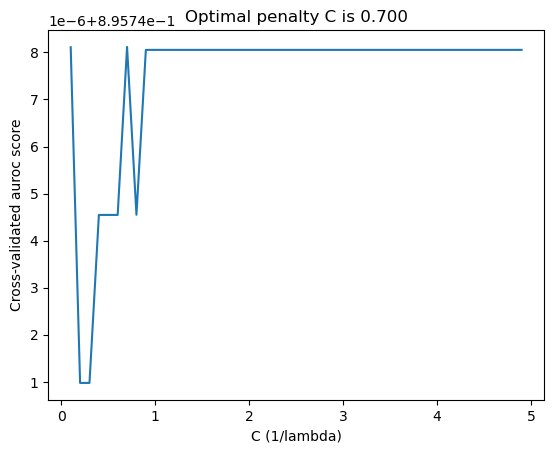

AUROC on test set is 0.916


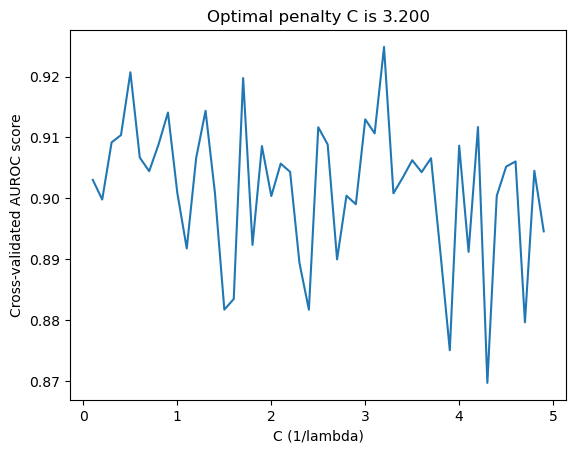

AUROC on test set is 0.924


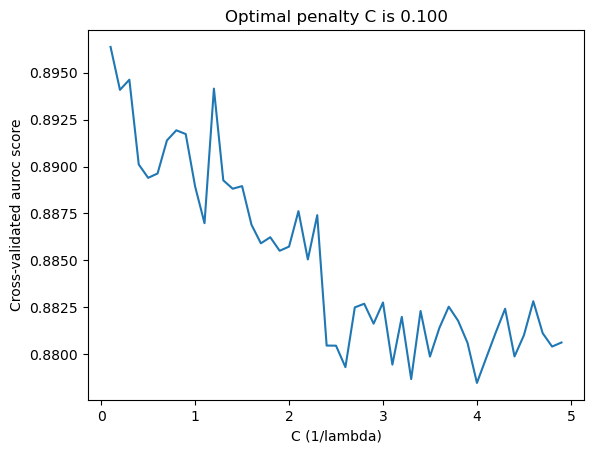

AUROC on test set is 0.908
Best performance model is  Linear SVC
Accuracy on entire training set: 0.974
AUROC on entire training set: 0.893


In [32]:
X = train.copy()

X = add_features(X)

y = X['label']
X = X.drop(['account.id', 'ID', 'label'], axis=1)

X_train,X_val,y_train,y_val = train_test_split(X, y, random_state=0,test_size=0.2)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

model = get_best_model(X_train_scaled, y_train, X_val_scaled, y_val)

X_scaled = scaler.transform(X)

model.fit(X_scaled,y)

preds = model.predict(X_scaled)
print('Accuracy on entire training set: {:.3f}'.format(accuracy_score(y,preds)))
print('AUROC on entire training set: {:.3f}'.format(roc_auc_score(y,preds)))

In [33]:
X_test = final_test.copy()

X_test = add_features(X_test)

X_test = X_test.drop(['ID'], axis=1)

preds = model.predict(X_test)

final_test['Predicted'] = preds

final_test[['ID', 'Predicted']].to_csv('../data/test_predictions.csv', index=False)

print("Submission file created!")

,ID,total_spent_in_subscriptions,watched_conductors,total_donated
0,001i000000NuQ6Y,5.0,0.0,1818.0
1,001i000000NuQXz,4.0,2.0,75.0
2,001i000000NuRDC,0.0,0.0,100.0
3,001i000000NuQeg,0.0,0.0,100.0
4,001i000000NuOQc,12.0,1.0,88.0


Submission file created!


/Users/jc/anaconda3/lib/python3.11/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
